In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11751576152222082892
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6707519816
locality {
  bus_id: 1
}
incarnation: 1338732232610056235
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [23]:
hello=tf.constant('Hello,TensorFlow!')
with tf.device("/gpu:0"):
    
    sess=tf.Session()
print(sess.run(hello))
print(tf.device)

b'Hello,TensorFlow!'
<function device at 0x0000015C26AB60D0>


In [2]:
width = 299
height = 299
channels = 3
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image

Using TensorFlow backend.


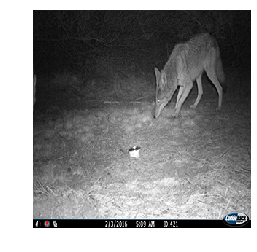

In [3]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("pic_db","coyote","test2.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [4]:
test_image = 2 * test_image - 1

In [5]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [6]:

fetch_pretrained_inception_v3()

In [7]:
import numpy as np
import tensorflow as tf

In [8]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [9]:
class_names = ["background"] + load_class_names()

In [10]:
class_names[:6]


['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

In [11]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [12]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [13]:
with tf.device("/gpu:0"):
    # Setup operations

    with tf.Session() as sess:


        saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt


In [14]:
np.expand_dims(test_image, axis=0)

array([[[[-0.90588236, -0.90588236, -0.90588236],
         [-0.92941177, -0.92941177, -0.92941177],
         [-0.88235295, -0.88235295, -0.88235295],
         ...,
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8666667 , -0.8666667 , -0.8666667 ]],

        [[-0.88235295, -0.88235295, -0.88235295],
         [-0.8980392 , -0.8980392 , -0.8980392 ],
         [-0.92941177, -0.92941177, -0.92941177],
         ...,
         [-0.827451  , -0.827451  , -0.827451  ],
         [-0.85882354, -0.85882354, -0.85882354],
         [-0.85882354, -0.85882354, -0.85882354]],

        [[-0.8980392 , -0.8980392 , -0.8980392 ],
         [-0.8980392 , -0.8980392 , -0.8980392 ],
         [-0.9137255 , -0.9137255 , -0.9137255 ],
         ...,
         [-0.88235295, -0.88235295, -0.88235295],
         [-0.92941177, -0.92941177, -0.92941177],
         [-0.8901961 , -0.8901961 , -0.8901961 ]],

        ...,

        [[-1.        , -1.        , -1

In [15]:
X_test = test_image.reshape(-1, height, width, channels)
with tf.device("/gpu:0"):
    # Setup operations


    with tf.Session() as sess:
        saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
        predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt


In [16]:
import numpy as np

In [17]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

273

In [18]:

class_names[most_likely_class_index]

'coyote, prairie wolf, brush wolf, Canis latrans'

In [19]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

coyote, prairie wolf, brush wolf, Canis latrans: 62.28%
grey fox, gray fox, Urocyon cinereoargenteus: 27.36%
red wolf, maned wolf, Canis rufus, Canis niger: 3.96%
red fox, Vulpes vulpes: 0.81%
timber wolf, grey wolf, gray wolf, Canis lupus: 0.41%
